In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans

df = pd.read_csv('social_marketing.csv')
print(df.head())

/Users/fmunting/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/fmunting/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


  Unnamed: 0  chatter  current_events  travel  photo_sharing  uncategorized  \
0  hmjoe4g3k        2               0       2              2              2   
1  clk1m5w8s        3               3       2              1              1   
2  jcsovtak3        6               3       4              3              1   
3  3oeb4hiln        1               5       2              2              0   
4  fd75x1vgk        5               2       0              6              1   

   tv_film  sports_fandom  politics  food  ...  religion  beauty  parenting  \
0        1              1         0     4  ...         1       0          1   
1        1              4         1     2  ...         0       0          0   
2        5              0         2     1  ...         0       1          0   
3        1              0         1     0  ...         0       1          0   
4        0              0         2     0  ...         0       0          0   

   dating  school  personal_fitness  fashion  smal

We are replacing missing values with 0, and dropping the ID column for now. ID is unique to each row and will lead to poor clustering. The tweet subjects will be normalized according to their column counts, but what about the tweet counts for each user? Will a prolific user skew the results dramatically?

In [2]:
df.fillna(0, inplace=True)

X = df.drop(columns=[df.columns[0]])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)   

#sns.histplot(x = "count", data = df_test)

The distribution of tweet counts is left-skewed, but we felt that the tail was small enough that we could proceed with only normalizing by column count. 

The dataset contains 37 variables. Some of these subjects look like they may be correlated, such as politics and news. We chose to perform principal components analysis in order to simplify the categorization of the tweets. The explained variance of the principal components trailed off at around 50% and 10 components. After this point each additional principal component explained less than 2.7% of the dataset variance, which is the same amount of explained variance as each individual variable assuming independence (1/37).

In [24]:
pca = PCA(n_components=36) 
X_pca = pca.fit_transform(X_scaled)

summary = pca.explained_variance_ratio_

explained_variance = summary
expl_var_df = pd.DataFrame(explained_variance)
expl_var_df = expl_var_df.rename(columns = {0:"explained_var"})

#plt.plot(expl_var_df.index, expl_var_df["explained_var"])
#plt.title("Cumulative Explained Variance by Number Principal Components")
#plt.xlabel("Principal Components")
#plt.ylabel("Cumulative Explained Variance")
#plt.show()

We decided to run our KMeans clustering with both the 37 raw input features and the 10 principal components in order to verify the accuracy of our clustering after principal components analysis.

In [25]:
kmeans = KMeans(n_clusters=3, random_state=42)
pca_clusters = kmeans.fit_predict(X_pca)
df['PCA_Cluster'] = pca_clusters

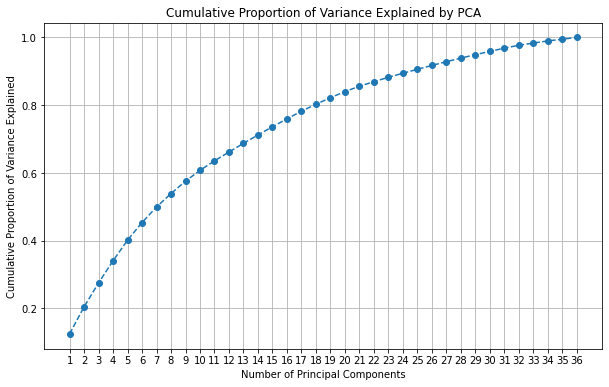

In [26]:
pca_columns = [f'PCA{i}' for i in range(1, 37)]
pca_df = pd.DataFrame(data = X_pca, columns = pca_columns)

pca2 = PCA()
# determine best number of PCs
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.title('Cumulative Proportion of Variance Explained by PCA')
plt.grid(True)
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.show()

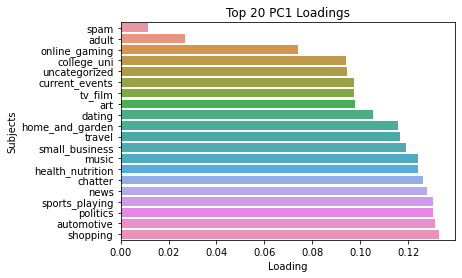

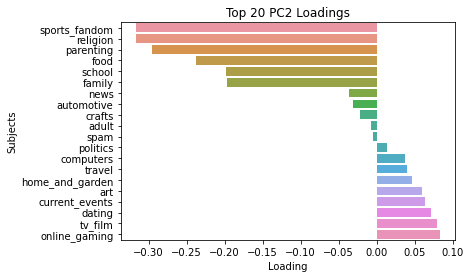

In [51]:
# keep 10 PCs since they account for ~50% of the original variance
pca_df = pca_df[['PCA1','PCA2', 'PCA3', 'PCA4','PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']]

# visualize loadings
PC1_loadings = pca.components_[0]
PC1_loadings_df = pd.DataFrame({'Subjects':X.columns, 'Loading':PC1_loadings})
PC1_loadings_df = PC1_loadings_df.sort_values(by = "Loading")[:20]
sns.barplot(data = PC1_loadings_df, x = 'Loading', y = 'Subjects')
plt.title('Top 20 PC1 Loadings')
plt.show()

PC2_loadings = pca.components_[1]
PC2_loadings_df = pd.DataFrame({'Subjects':X.columns, 'Loading':PC2_loadings})
PC2_loadings_df = PC2_loadings_df.sort_values(by = "Loading")[:20]
sns.barplot(data = PC2_loadings_df, x = 'Loading', y = 'Subjects')
plt.title('Top 20 PC2 Loadings')
plt.show()

In [52]:
all_clusters = kmeans.fit_predict(X_scaled)
df["Raw_Var_Cluster"] = all_clusters

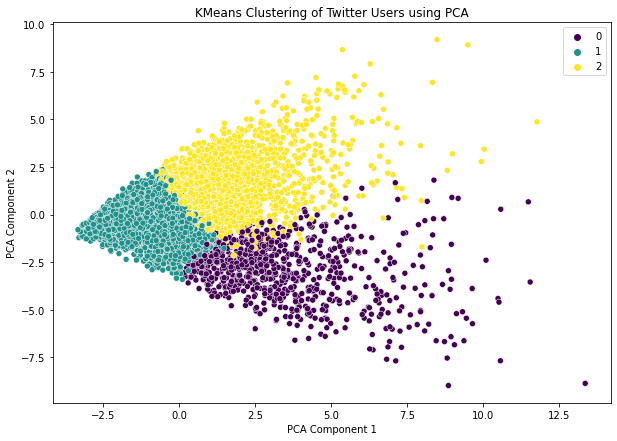

In [57]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=pca_clusters, palette='viridis')
plt.title('KMeans Clustering of Twitter Users using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

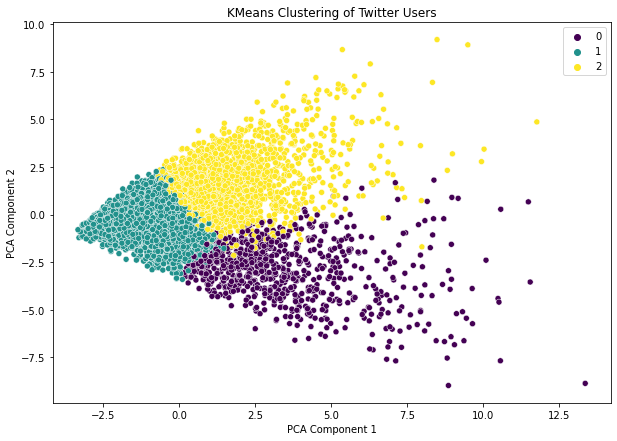

In [58]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=all_clusters, palette='viridis')
plt.title('KMeans Clustering of Twitter Users')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

The users are assigned to "different" clusters when comparing clustering with PCA and clustering with the raw predictor variables, but plotting them we see that these clusters occupy the same feature spaces but are labelled differently depending on which method you choose. We chose to use the principal components to identify the defining characteristics of our clusters. We felt that the PC's revealed the most uniquely identifying qualities of each market segment.

In [60]:
numeric_columns = df.select_dtypes(include=['number']).columns
cluster_analysis = df.groupby('PCA_Cluster')[numeric_columns].mean()
pd.set_option('display.max_columns', None) 

cluster_analysis

,chatter,current_events,travel,photo_sharing,uncategorized,tv_film,sports_fandom,politics,food,family,home_and_garden,music,news,online_gaming,shopping,health_nutrition,college_uni,sports_playing,cooking,eco,computers,business,outdoors,crafts,automotive,art,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult,PCA_Cluster,Raw_Var_Cluster
PCA_Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.080446,1.704208,1.524752,2.490099,0.736386,1.042079,5.878713,1.474010,4.570545,2.475248,0.665842,0.721535,1.193069,1.282178,1.368812,2.174505,1.457921,0.759901,1.714109,0.652228,0.823020,0.511139,0.756188,1.065594,1.070545,0.873762,5.306931,1.095297,4.037129,0.669554,2.676980,1.389851,1.032178,0.389851,0.006188,0.404703,0.0,0.0
1,3.595030,1.355673,1.239356,1.848238,0.666938,0.810145,0.984722,1.326950,0.821552,0.566510,0.405785,0.480953,0.922795,0.911998,0.940110,1.637808,1.121206,0.454879,0.986759,0.352007,0.433490,0.293339,0.530658,0.319821,0.626400,0.468935,0.512732,0.334488,0.463638,0.439601,0.404156,0.921776,0.482583,0.224282,0.004482,0.353229,1.0,1.0
2,6.339954,1.846651,2.391224,4.697921,1.172748,1.670670,1.376443,2.952887,1.519169,0.936721,0.727021,1.113164,1.851270,1.854503,2.415704,4.821247,2.554734,1.012009,4.397691,0.823557,1.072979,0.684988,1.363972,0.755196,1.201386,1.249423,0.844804,1.400000,0.796305,1.341339,0.879446,2.714088,2.148730,0.570439,0.011085,0.516397,2.0,2.0


In today's digital age, social media has become a powerful platform for individuals to express their interests, share their experiences, and connect with like-minded communities. For businesses and marketers, understanding the diverse audience segments within this vast online landscape is crucial for crafting effective, targeted campaigns. This report aims to uncover distinct market segments within a social media audience by analyzing users' engagement patterns across various content categories.
Using data clustering techniques, we have identified 3 unique profiles that represent different social media profiles, each characterized by their specific interests and levels of activity.

**C1: The It Girl**
Key Interests: Photo Sharing, Cooking, Shopping, College/University, Fashion
The It Girl is a dynamic and fashion-forward individual who enjoys staying ahead of the curve. They are active on social media, frequently sharing photos of their latest outfits, culinary creations, and shopping hauls. Their interest in fashion is not just about following trends but creating them, making them an influencer in their social circles. Whether it's exploring new recipes or showcasing their college life, this user is all about expressing themselves and inspiring others with their unique style and taste.

**C2: The Podcaster**
Key Interests: Politics, Travel, Photo Sharing, Sports Fandom, Food, News (Low Engagement)
The Podcaster is a user who dabbles in a variety of topics, from politics and news to travel and sports. While they may not engage deeply with any single interest, their curiosity drives them to stay informed and explore new ideas. They enjoy sharing travel experiences and food discoveries with their social network, often combining their love for exploration with a casual interest in current events and sports. This profile represents someone who values variety and enjoys experiencing a little bit of everything the world has to offer.

**C3: The Almond Mom**
Key Interests: Health & Nutrition, Personal Fitness, Cooking, Photo Sharing, Food
The Almond Mom is all about leading a healthy, balanced life. Their interests revolve around fitness, nutrition, and cooking, making them a source of inspiration for those looking to improve their well-being. They regularly share their healthy recipes and fitness routines, using photo-sharing platforms to document their journey towards a healthier lifestyle. Food is a central theme in their life, not just as nourishment but as a way to explore and share their passion for wellness. This profile embodies a user dedicated to making positive lifestyle choices and inspiring others to do the same.

**The best profiles for NutrientH20 would be the It Girl and The Almond Mom.**